In [70]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import gensim
from gensim import corpora, models


[nltk_data] Downloading package punkt to /home/victor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/victor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [71]:
df = pd.read_csv("extraction_twint/data_service_clients/wholefoods_computed.csv").filter(["tweet","reply_time"])

#reply time to timedelta
df['reply_time']=df['reply_time'].map(pd.to_timedelta)

#reply time in minutes
df['reply_time']=df['reply_time'].map(lambda x: x.days*1440 + x.seconds//60)

df.head(16000)

,tweet,reply_time
0,#DAM job opening - Senior Marketing Asset Mana...,NaN
1,"Finally, a holiday I can totally support. I'll...",NaN
2,@3rdHourTODAY please mention that there are op...,NaN
3,Thanks for bringing this to our attention. Thi...,NaN
4,"Riddle me this, Whole Foods. How the hell is M...",NaN
5,NEW: Enjoy #Austin Ice Skating on @WholeFoods ...,NaN
6,"Now through December 17, donate to @WholeFoods...",NaN
7,So this is fake news,NaN
8,great! i usually can rely on Fresh Pond. it’s ...,NaN
9,We have called the Fresh Pond location and the...,NaN


### Proportions de tweets avec/sans réponse

In [101]:
has_reply = df['reply_time'].map(lambda x : not(math.isnan(x)))

#plt.hist(has_reply)
has_reply.value_counts()/has_reply.size*100

False    85.078534
True     14.921466
Name: reply_time, dtype: float64

### Temps de réponse en jours

(array([1.656e+03, 3.940e+02, 1.010e+02, 4.100e+01, 3.900e+01, 1.700e+01,
        7.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5]),
 <a list of 19 Patch objects>)

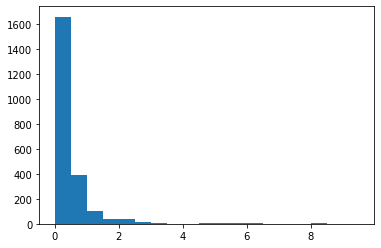

In [102]:
plt.hist(df['reply_time']/1440.0, np.arange(0,10,0.5))

### Temps de réponse en minutes

(array([ 26., 112., 127., 129., 115.,  87.,  87.,  53.,  43.,  29.,  27.,
         31.,  27.,  21.,  21.,  20.,   8.,   8.,   6.,   6.,  10.,   7.,
          9.,  10.,   7.,   5.,   7.,   8.,   6.,   8.,   4.,   6.,   8.,
          7.,   4.,   2.,   3.,   2.,   0.,   5.,   3.,   1.,   3.,   6.,
          1.,   4.,   0.,   0.,   0.,   2.,   2.,   2.,   4.,   2.,   3.,
          3.,   2.,   1.,   1.,   2.,   4.,   2.,   2.,   3.,   2.,   0.,
          0.,   1.,   2.,   1.,   2.,   2.,   2.,   1.,   0.,   4.,   1.,
          3.,   0.,   1.,   2.,   2.,   2.,   2.,   2.,   1.,   1.,   0.,
          3.,   2.,   0.,   0.,   2.,   2.,   0.,   1.,   1.,   0.,   1.,
          1.,   1.,   0.,   0.,   3.,   0.,   1.,   1.,   0.,   2.,   2.,
          0.,   1.,   1.,   2.,   2.,   6.,   4.,   1.,   0.,   1.,   2.,
          2.,   2.,   1.,   1.,   2.,   1.,   1.,   0.,   1.,   2.,   2.,
          1.,   3.,   2.,   0.,   1.,   1.,   0.,   2.,   2.,   1.,   0.,
          1.,   0.,   3.,   2.,   2., 

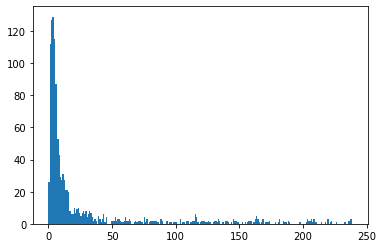

In [103]:
plt.hist(df['reply_time'], np.arange(0,240,1))

## 2. Filtration et tokenisation

In [104]:
sample = df['tweet']

##on enlève les valeurs nulles
sample = sample.dropna()

##tout en minuscules
sample = sample.str.lower()

## on enlève la punctuation
sample = sample.str.replace(r'[^\w\s]', '')

sample.head()

0    dam job opening  senior marketing asset manage...
1    finally a holiday i can totally support ill ta...
2    3rdhourtoday please mention that there are opt...
3    thanks for bringing this to our attention this...
4    riddle me this whole foods how the hell is mit...
Name: tweet, dtype: object

In [105]:
##on tokenise les phrases
sample=sample.map(lambda x: nltk.tokenize.word_tokenize(x))

In [106]:
##liste de stopwords
stop_words = stopwords.words('english')

In [107]:
##on supprime les stopwords
sample = sample.apply(lambda x: [item for item in x if item not in stop_words])
sample.head()

0    [dam, job, opening, senior, marketing, asset, ...
1    [finally, holiday, totally, support, ill, take...
2    [3rdhourtoday, please, mention, options, hair,...
3    [thanks, bringing, attention, valid, offer, we...
4    [riddle, whole, foods, hell, mitch, mcconnell,...
Name: tweet, dtype: object

In [108]:
##to be improved or skipped
stemmer = PorterStemmer()

sample=sample.apply(lambda x: [stemmer.stem(item) for item in x])
sample.head()

0    [dam, job, open, senior, market, asset, manag,...
1    [final, holiday, total, support, ill, take, oa...
2    [3rdhourtoday, pleas, mention, option, hair, d...
3    [thank, bring, attent, valid, offer, well, sha...
4    [riddl, whole, food, hell, mitch, mcconnel, pe...
Name: tweet, dtype: object

## 3. Bag of words

In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer

matrix = TfidfVectorizer(max_features=10)

X = matrix.fit_transform(df['tweet']).toarray()


In [117]:
y = has_reply

# split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [118]:
y[11]

False

In [119]:
# Naive Bayes 
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predict Class
y_pred = classifier.predict(X_test)

# Accuracy 
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred)

/home/victor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [122]:
accuracy

0.8468586387434555

In [121]:
y_pred

array([False, False, False, ..., False, False, False])

In [24]:
y_test

10243    Not replied
2481         Replied
4887     Not replied
5566     Not replied
2218     Not replied
10382    Not replied
2527         Replied
1758     Not replied
10950    Not replied
13018    Not replied
10130    Not replied
14044    Not replied
12714    Not replied
129      Not replied
12099    Not replied
10533        Replied
12138        Replied
1685     Not replied
9040     Not replied
6100     Not replied
9520     Not replied
9126         Replied
6552     Not replied
10146    Not replied
3254     Not replied
9163     Not replied
324          Replied
12394    Not replied
1469     Not replied
6811     Not replied
            ...     
9584         Replied
7302     Not replied
10386    Not replied
3098     Not replied
11227    Not replied
10939    Not replied
14493    Not replied
13222        Replied
8719     Not replied
13634    Not replied
4048     Not replied
1040     Not replied
11253        Replied
2009         Replied
9730         Replied
7375         Replied
9880     Not 

In [18]:
##compte des mots
def count_words(dataframe):
    counts = {}
    for phrase in dataframe:
        for word in phrase:
            if word in counts:
                counts[word]+=1
            else:
                counts[word]=1
    return pd.DataFrame({'word': list(counts.keys()),'count':list(counts.values())})

In [19]:
count_words(filtered_tokens).sort_values(by=['count'],ascending=False)

,word,count
7,wholefoods,7960
51,whole,1676
52,foods,1622
130,store,1277
134,like,1059
93,us,1006
164,amazon,907
250,im,722
771,market,721
328,magazine,720
